In [1]:
# from src.dataset_tools.databaseCache import DatabaseCache, RedisDataset
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import redis
import random
from mpl_toolkits.axes_grid1 import ImageGrid
from model.featureExtractor import FeatureExtractor
from losses.batchprovider import BatchProvider
from losses.batch_all_loss import BatchAllTripletLoss

# %set_env OUTPUT_DATASET_PATH=/media/sf_AI_City_challenge_dataset/AIC21_Track3_MTMC_Tracking/testing1
# %set_env DATASET_BASE_PATH=/media/sf_AI_City_challenge_dataset/AIC21_Track3_MTMC_Tracking/

In [2]:
batchProvider = BatchProvider()
batch_loader = torch.utils.data.DataLoader(batchProvider, num_workers=0)

batch = list(batch_loader) 
batch_tensor = batchProvider.create_batch_tensor(batch)
ids   = batchProvider.get_last_iter_labels()

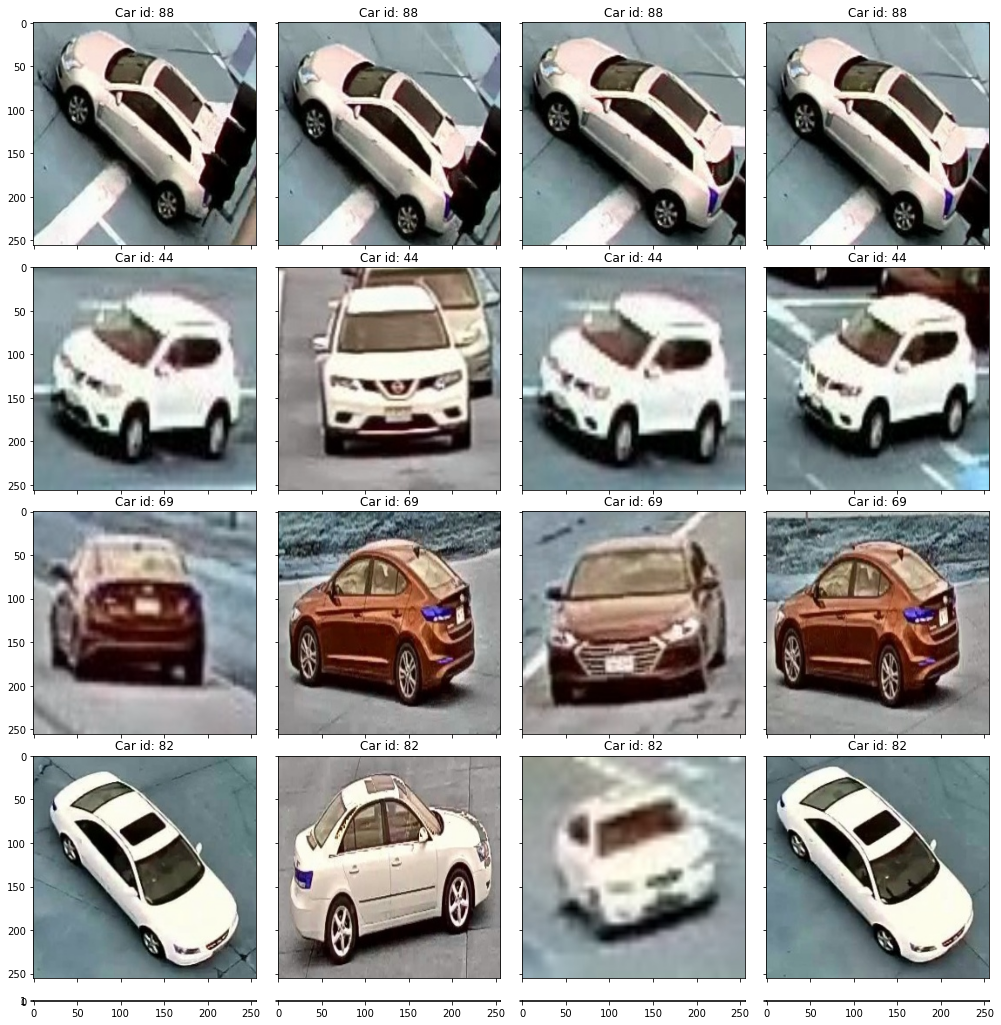

In [3]:

plot_batch = batch_tensor.permute(0, 2, 3, 1)
fig = plt.figure(figsize=(18., 18.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 4),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )


for ax, im, label in zip(grid, plot_batch, ids):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.title.set_text(f"Car id: {label}")

In [4]:
# Resnet18 backbone preprocess for input images 
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



In [41]:
model = FeatureExtractor(["avgpool"])     
_, embeddings = model(batch_tensor)

print(embeddings.squeeze())
print(torch.cdist(embeddings.squeeze(), embeddings.squeeze()))
# model.load_state_dict(torch.load("../model"))

tensor([[0.3556, 0.5557, 1.0238,  ..., 1.2084, 1.2947, 1.2796],
        [0.9286, 0.4977, 0.2420,  ..., 1.4806, 1.2216, 1.3189],
        [0.3728, 0.2975, 0.6816,  ..., 0.6103, 0.9915, 0.7844],
        ...,
        [0.9812, 1.4119, 1.3814,  ..., 0.4421, 0.7223, 0.7781],
        [0.9338, 0.5857, 0.5932,  ..., 0.7308, 0.0301, 0.0436],
        [1.8605, 0.5356, 1.7896,  ..., 0.5614, 1.6241, 1.7039]],
       grad_fn=<SqueezeBackward0>)
tensor([[ 0.0000, 13.8144, 14.2575, 13.3125, 19.9946, 21.0466, 18.6830, 18.9032,
         20.8478, 19.5086, 20.0249, 19.8549, 17.9799, 19.9045, 21.0186, 17.5077],
        [13.8144,  0.0000, 13.2618, 13.8059, 20.6582, 22.3538, 20.1830, 20.2872,
         20.8869, 20.4837, 20.1667, 20.3308, 19.2624, 20.8741, 20.8483, 18.9094],
        [14.2575, 13.2618,  0.0000,  9.0848, 18.6318, 20.8686, 17.7538, 18.4555,
         19.0712, 18.5782, 19.5047, 18.4602, 16.2829, 18.9426, 19.4536, 15.9680],
        [13.3125, 13.8059,  9.0848,  0.0000, 19.2083, 20.6752, 17.8234, 18.223

In [78]:
def get_positive_anchor_mask(labels):
    labels = torch.tensor(labels)
    indices_equal = torch.eye(len(labels), dtype=bool)
    indices_not_equal = torch.logical_not(indices_equal)

    # Check if label[i] == label[j]
    labels_equal = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))
    
    mask = torch.logical_and(indices_not_equal, labels_equal)

    return mask

def get_negative_anchor_mask(labels):
    labels = torch.tensor(labels)

    labels_not_equal = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))
    mask = torch.logical_not(labels_not_equal)

    return mask

def hard_negative_batch_triplet_loss(labels, embeddings, margin=1.0):
    embeddings = embeddings.squeeze()
    distance_matrix = torch.cdist(embeddings, embeddings)
    
    # Get hardest positive for each anchor
    mask_anchor_positive = get_positive_anchor_mask(labels)
    mask_anchor_positive = mask_anchor_positive.float()

    # Use only distances created from positive anchors ( they have same label )
    anchor_positive_dist = torch.mul(distance_matrix, mask_anchor_positive)
    
    hardest_positive_dist, _ = torch.max(anchor_positive_dist, dim=1, keepdim=True)
    
    # Get hardest negative for each anchor
    mask_anchor_negative = get_negative_anchor_mask(labels)
    mask_anchor_negative = mask_anchor_negative.float()
    
    # We need to invalidate negatives for negative max ( label(a) == label(n) )
    # We get maximum distance from distance matrix and then add this max dist to every invalid negative anchor
    max_anchor_negative_dist, _ = torch.max(distance_matrix, dim=1, keepdim=True)
    anchor_negative_dist = distance_matrix + max_anchor_negative_dist * (1.0 - mask_anchor_negative) 
    
    hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)
    
    # Calculate the triplet loss from positive and negatives hardest distances 
    triplet_loss = torch.clamp(hardest_positive_dist - hardest_negative_dist + margin, min=0.0)
    
    triplet_loss = torch.mean(triplet_loss)
    
    return triplet_loss

def create_triplet_mask(labels):
        indices_equal = torch.eye(len(labels), dtype=bool)
        indices_not_equal = torch.logical_not(indices_equal)
        i_not_equal_j = indices_not_equal.unsqueeze(2)
        i_not_equal_k = indices_not_equal.unsqueeze(1)
        j_not_equal_k = indices_not_equal.unsqueeze(0)
        
        distinct_indices = torch.logical_and(torch.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)
        
        labels = torch.Tensor(labels)
        label_equal = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))
        i_equal_j = label_equal.unsqueeze(2)
        i_equal_k = label_equal.unsqueeze(1)

        valid_labels = torch.logical_and(i_equal_j, torch.logical_not(i_equal_k))

        # Combine the two masks
        mask = torch.logical_and(distinct_indices, valid_labels)

        return mask

def weighted_triplet_loss(labels, embeddings, margin=1.0, alfa=1.0, beta=1.0):
        embeddings = embeddings.squeeze()
        distance_matrix = torch.cdist(embeddings, embeddings)
        anchor_positive_dist = distance_matrix.unsqueeze(2)
        anchor_negative_dist = distance_matrix.unsqueeze(1)

        triplet_loss = alfa*anchor_positive_dist - beta*anchor_negative_dist + margin
        mask = create_triplet_mask(labels)
        mask = mask.float()

        triplet_loss = torch.matmul(triplet_loss, mask)
        triplet_loss = torch.clamp(triplet_loss, min=0)   # element-wise max(elem, 0.00), remove negatives values
        
        num_positive_triplets = int(torch.sum(torch.where( triplet_loss > 1e-16, 1, 0))) # count number of triplets, where loss > 0, positive loss functions
        num_valid_triplets = torch.sum(mask)    # Count all triplets possible from batch 
        fraction_positive = num_positive_triplets / (num_valid_triplets + 1e-16)
        
        triplet_loss = torch.sum(triplet_loss) / (num_positive_triplets + 1e-16)
        
        return triplet_loss 

weighted_triplet_loss(ids, embeddings, alfa=1.2)


tensor(22.5299, grad_fn=<DivBackward0>)

In [23]:
loss = torch.nn.TripletMarginWithDistanceLoss()
optimizer = torch.optim.Adam(feature_extractor.parameters(), lr=0.025)

losses = []
id_embeddings = []

for batch_idx, batch in enumerate(anchor_loader):
    anchors_id, anchors_batch = batch
    
    positives_batch = db_cache.id_random_by_tuple(anchors_id, preprocess)
    negatives_batch = db_cache.exclude_id_random_image(anchors_id, BATCH_SIZE, preprocess)

    _, anchors_embeddings = feature_extractor(anchors_batch)
    _, positives_embeddings = feature_extractor(positives_batch)
    _, negatives_embeddings = feature_extractor(negatives_batch)

    for idx, anchor_id in enumerate(anchors_id):
        id_embedding = (anchor_id, anchors_embeddings[idx].detach().numpy())
        id_embeddings.append(id_embedding)

    anchor_dataset.anchors_id = []

    triplet_loss = loss(anchors_embeddings, positives_embeddings, negatives_embeddings)

    if batch_idx % 30 == 0:
        train_eval()
        losses.append((batch_idx, triplet_loss))
        print(f"{batch_idx}: {triplet_loss}")

    
    optimizer.zero_grad()
    triplet_loss.backward()
    optimizer.step()
    
    

0: 0.27396056056022644


KeyboardInterrupt: 